In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import scipy
from sklearn import linear_model
from sklearn import neighbors
from sklearn.cross_decomposition import PLSRegression

In [109]:
# Import data

dc = pd.read_csv('/Users/justinsmith/Documents/GitHub/DC_Properties.csv')

/Users/justinsmith/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [110]:
# Data to clean and model

dc_re = dc.dropna(subset=['PRICE'])

In [111]:
# Seperating residential and condominium  

dc_re_resid = dc_re[dc_re['SOURCE'] == 'Residential']
dc_re_condo = dc_re[dc_re['SOURCE'] != 'Residential']

In [112]:
# exploring data

dc_re_resid['diff_yr'] = abs(dc_re_resid['EYB']- dc_re_resid['YR_RMDL'])
dc_re_condo['diff_yr'] = abs(dc_re_condo['EYB']- dc_re_condo['YR_RMDL'])
dc_re_resid = dc_re_resid.drop(index=56600)

/Users/justinsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/justinsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


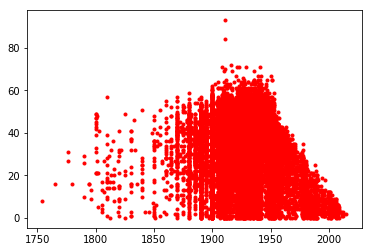

In [113]:
plt.plot(dc_re_resid['AYB'], dc_re_resid['diff_yr'], 'r.')

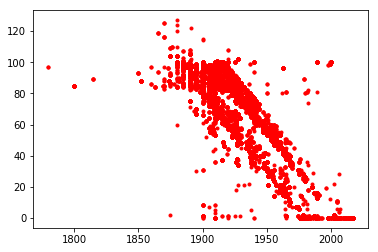

In [114]:
plt.plot(dc_re_condo['AYB'], dc_re_condo['diff_yr'], 'r.')

In [116]:
# Filling NA in year columns

dc_re_resid['AYB'] = dc_re_resid['AYB'].fillna(0)
dc_re_resid['YR_RMDL'] = dc_re_resid['YR_RMDL'].fillna(0)
dc_re_resid['EYB'] = dc_re_resid['EYB'].fillna(0)

In [117]:
# Cleaning actual year built, year remodel, and effective year built. 

for i in range(len(dc_re_resid)):
    if dc_re_resid.iloc[i,8] == 0:
        dc_re_resid.iloc[i,8] = dc_re_resid.iloc[i,10]

for i in range(len(dc_re_resid)):
    if dc_re_resid.iloc[i,9]  == 0:
        dc_re_resid.iloc[i,9] = dc_re_resid.iloc[i,10]\
        
for i in range(len(dc_re_resid)):
    if dc_re_resid.iloc[i,8] > dc_re_resid.iloc[i,10]:
        dc_re_resid.iloc[i,10] = dc_re_resid.iloc[i,8]
        
for i in range(len(dc_re_resid)):
    if dc_re_resid.iloc[i,10] > dc_re_resid.iloc[i,9]:
        dc_re_resid.iloc[i,9] = dc_re_resid.iloc[i,10]

In [118]:
# DEALING WITH NULLS AND COLUMNS

dc_re_resid.dropna(axis=1, how='all', inplace=True)
dc_re_resid.drop(columns=['Unnamed: 0','FULLADDRESS', 'CENSUS_BLOCK', 'diff_yr', 'NATIONALGRID',
                          'ASSESSMENT_SUBNBHD','X','Y','GIS_LAST_MOD_DTTM','SOURCE', 
                          'QUADRANT', 'SALE_NUM'], inplace=True)
dc_re_resid.dropna(inplace=True)

In [119]:
# Cleaning data types

dc_re_resid['SALEDATE']  = pd.to_datetime(dc_re_resid['SALEDATE']).dt.date
dc_re_resid['SALEDATE']= pd.to_datetime(dc_re_resid['SALEDATE'])

dc_re_resid['WARD'] = dc_re_resid['WARD'].str.extract('(\d+)', expand=False)
dc_re_resid['WARD'] = dc_re_resid['WARD'].astype('int')

dc_re_resid['SQUARE'].replace(to_replace='PAR ', value= 9999, inplace=True)
dc_re_resid['SQUARE'] = dc_re_resid['SQUARE'].astype('int')

dc_re_resid['USECODE'] = dc_re_resid['USECODE'].astype('int')

In [120]:
# Dealing with date of sale data

dc_re_resid[['year','month','day']] = dc_re_resid.SALEDATE.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))
dc_re_resid.drop(columns=['day','SALEDATE'], inplace=True)

In [122]:
dc_re_resid_dummies = pd.get_dummies(dc_re_resid)

In [123]:
X = dc_re_resid_dummies.drop(columns='PRICE')
y = dc_re_resid_dummies['PRICE'].values.reshape(-1, 1)

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=36)

In [125]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [126]:
print('\nCoefficients: \n', regr.coef_)


Coefficients: 
 [[ 3.93960701e+04  1.75739392e+04 -1.21838455e+05 -1.40145909e+03
  -5.24182557e+03 -1.76310788e+03 -1.02908330e+03  2.12099769e+03
   7.11771321e+02  1.83966074e+02  1.31839093e+06  4.12502081e+04
   3.73320923e+04  7.06128824e+03  3.91352747e+01  1.56763054e+03
  -9.16402553e+05 -2.57395138e+06 -4.76588624e+00 -2.12273532e+04
  -1.34216029e+01 -5.84612214e+04  3.38070851e+04  2.71100495e+04
   8.71643141e+03 -2.87118852e+05  1.42869524e+04  6.57055356e+04
   1.74089993e+04  4.42734286e+04  1.91341248e+04  2.94258234e+04
   1.08622442e+04  4.30602830e+04  3.17891164e+04 -1.18131485e+05
   6.69635796e+04  5.11679053e+04  4.08547973e+04 -4.08547973e+04
   1.72431278e+04 -1.77163080e+04  4.01369145e+04 -2.26351645e+04
  -4.05866793e+04 -2.52947611e+04 -3.39895942e+04 -5.24780853e+04
   5.51152924e+05  1.35108573e+04 -1.37441182e+05 -2.14613288e+05
   2.23281775e+04 -1.57884215e+05  7.87562890e+04 -2.04890134e+04
   2.77650543e-08 -4.91298306e+05 -4.90871164e+04  6.403919

In [127]:
print('\nIntercept: \n', regr.intercept_)


Intercept: 
 [-1.91053574e+08]


In [128]:
print('\nR-squared:')
print(regr.score(X_train, y_train))


R-squared:
0.7503923939238798


In [129]:
y_pred_regr = regr.predict(X_test)

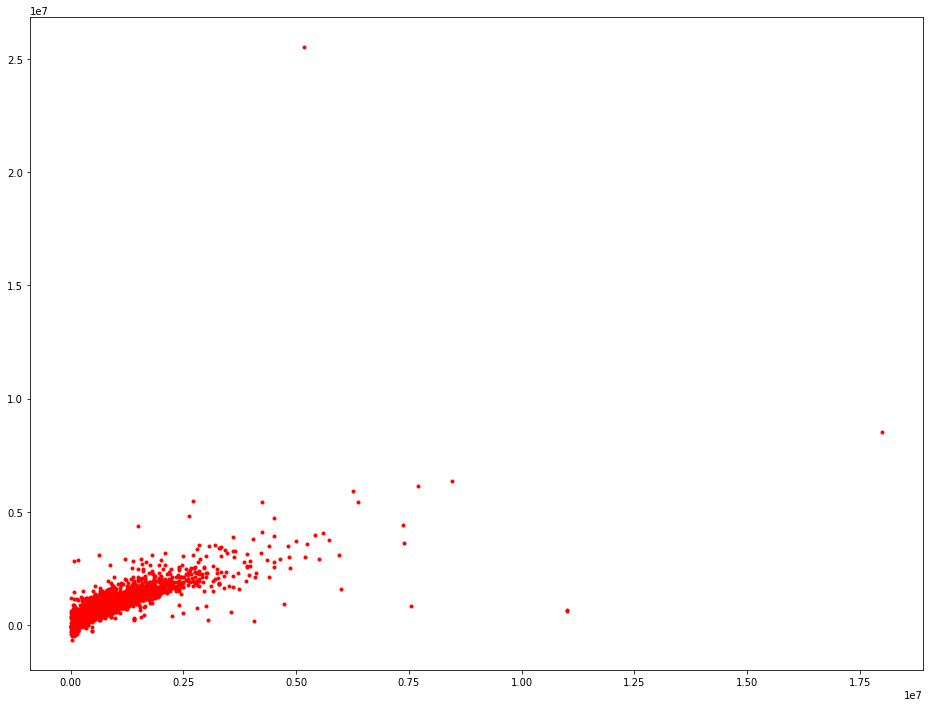

In [131]:
plt.figure(figsize=(16,12))
plt.plot(y_test, y_pred_regr,'r.')

In [132]:
pls1 = PLSRegression(n_components=25)

In [133]:
fit = pls1.fit(X_train, y_train)

In [134]:
pls1.fit(X_test, y_test)

PLSRegression(copy=True, max_iter=500, n_components=25, scale=True, tol=1e-06)

In [77]:
pls1.score(X_test,y_test)

0.7513591582752291

In [135]:
Y_PLS_pred = fit.predict(X_test)

In [136]:
print(max(Y_PLS_pred))

[10434497.37657589]


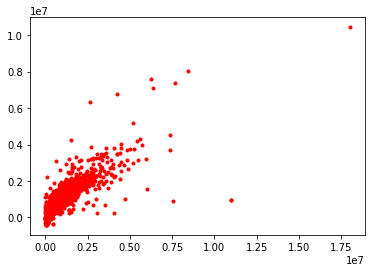

In [137]:
plt.plot(y_test,Y_PLS_pred, 'r.')

In [138]:
ridgeregr = linear_model.Ridge(alpha=5, fit_intercept=False) 
ridgeregr.fit(X_train, y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [139]:
ridgeregr.score(X_train,y_train)

0.7353631473044959

In [140]:
ridgeregr.score(X_test, y_test)

0.7101540092826568

In [141]:
lass = linear_model.Lasso(alpha=.5)

In [142]:
lass.fit(X_train, y_train)

/Users/justinsmith/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [145]:
lass.score(X_train, y_train)

0.7503916642323554

In [146]:
lass.score(X_test, y_test)

0.6260100113878064

In [147]:
lass_pred = lass.predict(X_test)

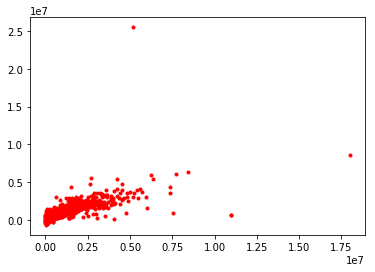

In [148]:
plt.plot(y_test, lass_pred, 'r.')

In [149]:
from sklearn.ensemble import RandomForestRegressor

In [153]:
names = X_train.columns
rfr = RandomForestRegressor()

In [154]:
rfr.fit(X_train, y_train)

/Users/justinsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [155]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfr.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.3205, 'GBA'), (0.0891, 'LONGITUDE'), (0.0884, 'SQUARE'), (0.0627, 'EYB'), (0.0346, 'LANDAREA'), (0.0332, 'AYB'), (0.0245, 'BATHRM'), (0.0202, 'LATITUDE'), (0.0199, 'CENSUS_TRACT'), (0.0184, 'YR_RMDL'), (0.0174, 'CNDTN_Average'), (0.0153, 'CNDTN_Default'), (0.0146, 'STRUCT_Default'), (0.0119, 'BEDRM'), (0.011, 'GRADE_No Data'), (0.0108, 'year_2017'), (0.0102, 'NUM_UNITS'), (0.0094, 'WARD'), (0.0081, 'GRADE_Exceptional-D'), (0.008, 'year_2018'), (0.0072, 'GRADE_Exceptional-C'), (0.0064, 'ZIPCODE'), (0.0063, 'ASSESSMENT_NBHD_Georgetown'), (0.0061, 'ROOMS'), (0.006, 'FIREPLACES'), (0.0057, 'BLDG_NUM'), (0.0056, 'year_2016'), (0.0055, 'CNDTN_Very Good'), (0.0053, 'QUALIFIED_U'), (0.0053, 'CNDTN_Excellent'), (0.0052, 'QUALIFIED_Q'), (0.0042, 'year_2015'), (0.0036, 'EXTWALL_Metal Siding'), (0.0035, 'KITCHENS'), (0.0031, 'ASSESSMENT_NBHD_Randle Heights'), (0.0029, 'year_1998'), (0.0029, 'HF_BATHRM'), (0.0028, 'GRADE_Exceptional-B'), (0.0027, 'year_2013'), (0

In [156]:
rfr.score(X_train,y_train)

0.9447836782086187

In [157]:
rfr.score(X_test, y_test)

0.7399579583838796